### Imports

In [80]:
import requests as rq
import pandas as pd
import numpy as np
import datetime as dt
import traceback as tb
import seaborn as sb

from scipy import optimize
from scipy import integrate

### Download & plot data

In [112]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(int(d['dailyconfirmed']))
        r['deceased'].append(int(d['dailydeceased']))
        r['recovered'].append(int(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)

In [113]:
df.head()

,date,confirmed,deceased,recovered
0,2020-01-30,1,0,0
1,2020-01-31,0,0,0
2,2020-02-01,0,0,0
3,2020-02-02,1,0,0
4,2020-02-03,1,0,0


In [114]:
# remove first 37 days of data. not consequential.
fdf = df[37:][:]
fdf.reset_index(drop=True, inplace=True)
fdf.head()

,date,confirmed,deceased,recovered
0,2020-03-07,3,0,0
1,2020-03-08,5,0,0
2,2020-03-09,9,0,0
3,2020-03-10,15,0,1
4,2020-03-11,8,0,0


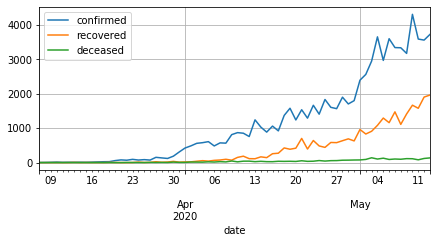

In [115]:
# plot downloaded data
fdf.plot(
    x='date',
    y=['confirmed', 'recovered', 'deceased'],
    figsize=(7,3),
    grid=True
)

### Compute & plot Re (effective reproduction number)

In [117]:
fdf['re'] = fdf['confirmed'] / fdf['confirmed'].shift(1, fill_value=1)
fdf['sma_re'] = fdf['re'].rolling(7, min_periods=1, center=True).mean().rolling(7, min_periods=1, center=True).mean()
fdf.tail()

,date,confirmed,deceased,recovered,re,sma_re
63,2020-05-09,3175,115,1414,0.950883,1.035182
64,2020-05-10,4311,112,1669,1.357795,1.037379
65,2020-05-11,3592,81,1579,0.833217,1.031726
66,2020-05-12,3562,120,1905,0.991648,1.035391
67,2020-05-13,3726,136,1964,1.046042,1.034496


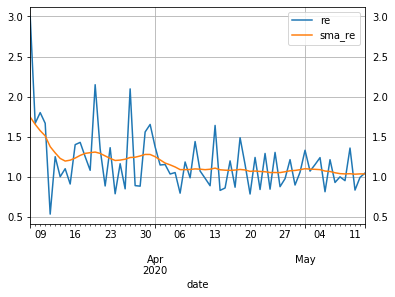

In [118]:
ax = fdf.plot(
    x='date',
    y=['re', 'sma_re'],
    grid=True
)
ax.tick_params(labeltop=False, labelright=True)

### Learning to fit a sample curve

In [119]:
# define a simple function
def y(x, a, b):
    return a * x * x + b

# generate multiplier between 0.9 and 1.1 to noisy test data for fitting
import random
def m():
    return 0.9 + 0.2 * random.random()

test_data = [2 * x * x * m() + 10 for x in range(10)] # so a=2 and b=10 in test data
print("actual output:", [f"{y(i, 2, 10):0.2f}" for i in range(10)])
print("values to fit:", [f"{i:0.2f}" for i in test_data])

# fit test data to function and try to find params
out = optimize.curve_fit(y, np.arange(10), test_data)
print ("param:", out[0])
print ("covar:\n", out[1])

actual output: ['10.00', '12.00', '18.00', '28.00', '42.00', '60.00', '82.00', '108.00', '138.00', '172.00']
values to fit: ['10.00', '12.10', '17.24', '28.77', '40.86', '63.99', '82.57', '110.05', '148.59', '180.72']
param: [2.12220067 9.00658838]
covar:
 [[ 7.19093791e-04 -2.04941729e-02]
 [-2.04941729e-02  1.10258651e+00]]


### SIR Model

In [120]:
def diff_eqns(y, t, beta, gamma, N):
    St, It, Rt = y
    dsdt = -beta * St * It / N
    didt = beta * St * It / N - gamma * It
    drdt = gamma * It
    return [dsdt, didt, drdt]

def sir_model(t, beta, gamma, I0, N):
    S0 = N - I0
    R0 = 0
    out = integrate.odeint(diff_eqns, (S0, I0, R0), t, args=(beta, gamma, N))
    S, I, R = out.T
    return S, I, R

### Sample plot of SIR model

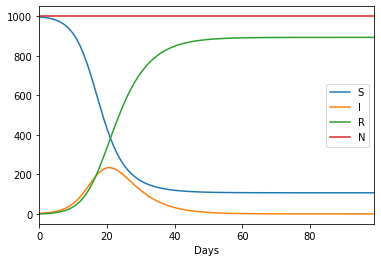

In [121]:
I0 = 3
N = 1000
beta = 0.5
gamma = 0.2
days = np.arange(100)
S, I, R = sir_model(days, beta, gamma, I0, N)

r = {
    'Days': days,
    'S': S,
    'I': I,
    'R': R
}

df = pd.DataFrame(r)
df['N'] = df['S'] + df['I'] + df['R']

df.plot(
    'Days',
    ['S', 'I', 'R', 'N']
)

### Try to fit the sample output back

In [122]:
def sir_model_apartment_inf(days, beta, gamma):
    I0 = 3
    N = 1000
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

days = np.arange(100)
I = sir_model_apartment_inf(days, 0.5, 0.2)
op.curve_fit(sir_model_apartment_inf, df['Days'], df['I'])

(array([0.5, 0.2]), array([[4.23127455e-34, 1.88000344e-34],
        [1.88000344e-34, 2.08497191e-34]]))

### Try to fit real data

beta, gamma: [6.50677047 6.39445751]
covariance:
 [[1220.71137686 1220.49233366]
 [1220.49233366 1220.27333055]]
r0: 1.0175641113586649


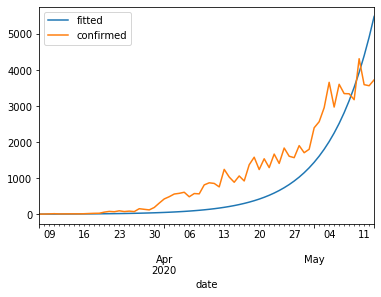

In [123]:
def sir_model_india_inf(days, beta, gamma):
    I0 = 3 #mar 3
    N = 1300000000 #130 crores
    I = sir_model(days, beta, gamma, I0, N)[1]
    return I

params, cov = op.curve_fit(sir_model_india_inf, fdf.index, fdf.confirmed)

print("beta, gamma:", params)
print("covariance:\n", cov)
print("r0:", params[0]/params[1])

fdf['fitted'] = sir_model_india_inf(fdf.index, *params)
ax = fdf.plot(
    x='date',
    y='fitted'
)
fdf.plot(
    x='date',
    y='confirmed',
    ax=ax
)

### Evaluate peak per the fitted curve

Text(112, 207671.96784806415, 'Peak Infections\n194085')

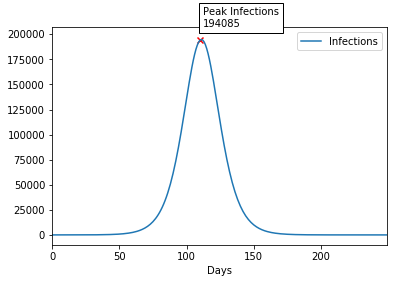

In [133]:
days = np.arange(250)
infs = sir_model_india_inf(days, *params)
r = {
    'Days': days,
    'Infections': infs
}
df = pd.DataFrame(r)
ax = df.plot(
    x='Days',
    y='Infections'
)

peakx = 110
ax.scatter([peakx], [df['Infections'].iloc[peakx]], c='red', marker='x')
ax.text(
    peakx + 2,
    df['Infections'].iloc[peakx] * 1.07,
    "Peak Infections\n" + str(int(df['Infections'].iloc[peakx])), 
    bbox={'facecolor':'white'}
)

In [127]:
dt.datetime(day=7, month=3, year=2020) + dt.timedelta(days=110)

datetime.datetime(2020, 6, 25, 0, 0)